# Inspecting data

In [1]:
pip install texthero

In [2]:
# Import libraries
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import texthero as hero
from texthero import preprocessing

In [3]:
# Read csv
data = pd.read_csv('https://raw.githubusercontent.com/picklesueat/data_jobs_data/master/DataScientist.csv');
data

,Unnamed: 0,index,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,Type of ownership,Industry,Sector,Revenue,Competitors,Easy Apply
0,0,0,Senior Data Scientist,$111K-$181K (Glassdoor est.),"ABOUT HOPPER\n\nAt Hopper, we’re on a mission ...",3.5,Hopper\n3.5,"New York, NY","Montreal, Canada",501 to 1000 employees,2007,Company - Private,Travel Agencies,Travel & Tourism,Unknown / Non-Applicable,-1,-1
1,1,1,"Data Scientist, Product Analytics",$111K-$181K (Glassdoor est.),"At Noom, we use scientifically proven methods ...",4.5,Noom US\n4.5,"New York, NY","New York, NY",1001 to 5000 employees,2008,Company - Private,"Health, Beauty, & Fitness",Consumer Services,Unknown / Non-Applicable,-1,-1
2,2,2,Data Science Manager,$111K-$181K (Glassdoor est.),Decode_M\n\nhttps://www.decode-m.com/\n\nData ...,-1.0,Decode_M,"New York, NY","New York, NY",1 to 50 employees,-1,Unknown,-1,-1,Unknown / Non-Applicable,-1,True
3,3,3,Data Analyst,$111K-$181K (Glassdoor est.),Sapphire Digital seeks a dynamic and driven mi...,3.4,Sapphire Digital\n3.4,"Lyndhurst, NJ","Lyndhurst, NJ",201 to 500 employees,2019,Company - Private,Internet,Information Technology,Unknown / Non-Applicable,"Zocdoc, Healthgrades",-1
4,4,4,"Director, Data Science",$111K-$181K (Glassdoor est.),"Director, Data Science - (200537)\nDescription...",3.4,United Entertainment Group\n3.4,"New York, NY","New York, NY",51 to 200 employees,2007,Company - Private,Advertising & Marketing,Business Services,Unknown / Non-Applicable,"BBDO, Grey Group, Droga5",-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3904,3904,4375,AWS Data Engineer,$55K-$112K (Glassdoor est.),About Us\n\nTachyon Technologies is a Digital ...,4.4,Tachyon Technologies\n4.4,"Dublin, OH","Irving, TX",201 to 500 employees,2011,Company - Private,IT Services,Information Technology,$10 to $25 million (USD),-1,-1
3905,3905,4376,Data Analyst â Junior,$55K-$112K (Glassdoor est.),"Job description\nInterpret data, analyze resul...",5.0,"Staffigo Technical Services, LLC\n5.0","Columbus, OH","Woodridge, IL",51 to 200 employees,2008,Company - Private,IT Services,Information Technology,$50 to $100 million (USD),-1,-1
3906,3906,4377,Security Analytics Data Engineer,$55K-$112K (Glassdoor est.),Job DescriptionThe Security Analytics Data Eng...,3.8,"PDS Tech, Inc.\n3.8","Dublin, OH","Irving, TX",5001 to 10000 employees,1977,Company - Private,Staffing & Outsourcing,Business Services,$100 to $500 million (USD),-1,-1
3907,3907,4378,Security Analytics Data Engineer,$55K-$112K (Glassdoor est.),The Security Analytics Data Engineer will inte...,4.0,Data Resource Technologies\n4.0,"Dublin, OH","Omaha, NE",1 to 50 employees,-1,Company - Private,Accounting,Accounting & Legal,Less than $1 million (USD),-1,-1


From a glance, it looks like any missing data has a value of -1.

In [4]:
# Check all the columns and their corresponding data types
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3909 entries, 0 to 3908
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         3909 non-null   int64  
 1   index              3909 non-null   int64  
 2   Job Title          3909 non-null   object 
 3   Salary Estimate    3909 non-null   object 
 4   Job Description    3909 non-null   object 
 5   Rating             3909 non-null   float64
 6   Company Name       3909 non-null   object 
 7   Location           3909 non-null   object 
 8   Headquarters       3909 non-null   object 
 9   Size               3909 non-null   object 
 10  Founded            3909 non-null   int64  
 11  Type of ownership  3909 non-null   object 
 12  Industry           3909 non-null   object 
 13  Sector             3909 non-null   object 
 14  Revenue            3909 non-null   object 
 15  Competitors        3909 non-null   object 
 16  Easy Apply         3909 

In [5]:
# Check some statistics of numerical data
data.describe()

,Unnamed: 0,index,Rating,Founded
count,3909.000000,3909.000000,3909.000000,3909.000000
mean,1954.000000,2167.446662,3.283576,1479.154771
std,1128.575429,1247.657849,1.575749,855.750138
min,0.000000,0.000000,-1.000000,-1.000000
25%,977.000000,1121.000000,3.200000,1625.000000
50%,1954.000000,2161.000000,3.700000,1976.000000
75%,2931.000000,3249.000000,4.100000,2002.000000
max,3908.000000,4379.000000,5.000000,2020.000000


In [6]:
# Rows and columns
data.shape

(3909, 17)

In [7]:
# Check for unique location values
len(pd.unique(data['Location']))

191

In [8]:
# Check unique location value counts
data["Location"].value_counts()

Austin, TX             345
Chicago, IL            330
San Diego, CA          304
New York, NY           303
Houston, TX            219
                      ... 
Hermosa Beach, CA        1
Gloucester City, NJ      1
Missouri City, TX        1
West Menlo Park, CA      1
Venice, CA               1
Name: Location, Length: 191, dtype: int64

In [9]:
# Check for unique salary values
len(pd.unique(data['Salary Estimate']))

148

In [10]:
# Check unique salary value counts
data["Salary Estimate"].value_counts()

$93K-$151K (Glassdoor est.)         62
$113K-$180K (Glassdoor est.)        61
$111K-$175K (Glassdoor est.)        60
$71K-$122K (Glassdoor est.)         60
$119K-$147K (Glassdoor est.)        44
                                    ..
$39K-$71K (Glassdoor est.)           7
$99K-$173K (Glassdoor est.)          6
$10-$26 Per Hour(Glassdoor est.)     3
$146K-$175K (Glassdoor est.)         3
$41K-$74K (Glassdoor est.)           1
Name: Salary Estimate, Length: 148, dtype: int64

Looks like there are 2 different measures of salary: yearly and hourly. I want to check how many hourly values there are, and I will convert them into yearly salary.

In [11]:
hr_sal_count=data['Salary Estimate'].str.contains('Per Hour').sum()
hr_sal_count

21

Since this salary column contains a range, I would want to separate this column into 2 columns: min salary and max salary in the preprocessing step.

# Preprocessing

First, I am going to drop unecessary columns.

In [12]:
data.drop(["Unnamed: 0","index","Rating", "Company Name", "Headquarters", "Size", "Founded", "Type of ownership", "Industry", "Sector", "Revenue", "Competitors", "Easy Apply"],axis=1,inplace=True)

I want to check for null data again to ensure there are no nulls. Since null data has -1 values, I will replace -1 with NaN.

In [13]:
data.replace(['-1'], [np.NaN], inplace=True)
data.replace(['-1.0'], [np.NaN], inplace=True)
data.replace([-1], [np.NaN], inplace=True)

In [14]:
data.isnull().sum()

Job Title          0
Salary Estimate    0
Job Description    0
Location           0
dtype: int64

Since the columns I will be using for my tasks don't contain nulls, I will keep the data the way it is.

Now, I am going to convert hourly salary to yearly salary. Assuming that the number of hours per week for full time jobs is 40, and there are 52 weeks in a year.

In [15]:
hrs_per_wk = 40
wks_per_yr = 52
# Loop through all the rows
for i in range(data.shape[0]):
    sal_est = data.loc[i,"Salary Estimate"]
    sal_est = sal_est.replace("$", "") # remove $
    # replace hourly salary with yearly salary and split into min and max
    if "Per Hour" in sal_est:
        l, u = sal_est.split("-")
        u, _ = u.split("Per")
        u = u.strip()
        l = int(l) * hrs_per_wk * wks_per_yr *(1/1000)
        u = int(u) * hrs_per_wk * wks_per_yr *(1/1000)
    # split yearly salary into min and max    
    else:
        l, u = sal_est.split("-")
        l = l.replace("K", "") # remove K 
        u, _= u.split("(")
        u = u.replace("K", "")
        u = u.strip()
    
    # Create new columns   
    l = int(l)
    u = int(u)
    data.loc[i,"Lower_Salary"] = l
    data.loc[i,"Upper_Salary"] = u


In [16]:
data

,Job Title,Salary Estimate,Job Description,Location,Lower_Salary,Upper_Salary
0,Senior Data Scientist,$111K-$181K (Glassdoor est.),"ABOUT HOPPER\n\nAt Hopper, we’re on a mission ...","New York, NY",111.0,181.0
1,"Data Scientist, Product Analytics",$111K-$181K (Glassdoor est.),"At Noom, we use scientifically proven methods ...","New York, NY",111.0,181.0
2,Data Science Manager,$111K-$181K (Glassdoor est.),Decode_M\n\nhttps://www.decode-m.com/\n\nData ...,"New York, NY",111.0,181.0
3,Data Analyst,$111K-$181K (Glassdoor est.),Sapphire Digital seeks a dynamic and driven mi...,"Lyndhurst, NJ",111.0,181.0
4,"Director, Data Science",$111K-$181K (Glassdoor est.),"Director, Data Science - (200537)\nDescription...","New York, NY",111.0,181.0
...,...,...,...,...,...,...
3904,AWS Data Engineer,$55K-$112K (Glassdoor est.),About Us\n\nTachyon Technologies is a Digital ...,"Dublin, OH",55.0,112.0
3905,Data Analyst â Junior,$55K-$112K (Glassdoor est.),"Job description\nInterpret data, analyze resul...","Columbus, OH",55.0,112.0
3906,Security Analytics Data Engineer,$55K-$112K (Glassdoor est.),Job DescriptionThe Security Analytics Data Eng...,"Dublin, OH",55.0,112.0
3907,Security Analytics Data Engineer,$55K-$112K (Glassdoor est.),The Security Analytics Data Engineer will inte...,"Dublin, OH",55.0,112.0


For easier calculations, I will calculate the midpoint salary based on the lower and upper bound. 
Midpoint = (lower + upper) / 2

In [17]:
data['Midpoint Salary'] = data.apply(lambda row: (row.Lower_Salary + row.Upper_Salary)/2, axis=1)

In [18]:
data['Midpoint Salary']

0       146.0
1       146.0
2       146.0
3       146.0
4       146.0
        ...  
3904     83.5
3905     83.5
3906     83.5
3907     83.5
3908     83.5
Name: Midpoint Salary, Length: 3909, dtype: float64

Now I will clean the text data from the Job Description using the clean method from TextHero library. This will fill in missing data, lowercase all the words, remove urls, whitespace, punctuation, digits, and stop words.

In [19]:
custom_pipeline = [preprocessing.fillna,
                   preprocessing.lowercase,
                   preprocessing.remove_urls,                   
                   preprocessing.remove_punctuation,
                   preprocessing.remove_digits,                
                   preprocessing.remove_stopwords,
                   preprocessing.remove_whitespace
                   ]

In [20]:
data['JD'] = data['Job Description'].pipe(hero.clean, custom_pipeline)


In [21]:
data['JD']

0       hopper hopper mission make booking travel fast...
1       noom use scientifically proven methods help us...
2       decode data science manager job description hi...
3       sapphire digital seeks dynamic driven mid leve...
4       director data science description edelman inte...
                              ...                        
3904    us tachyon technologies digital transformation...
3905    job description interpret data analyze results...
3906    job descriptionthe security analytics data eng...
3907    security analytics data engineer interface sec...
3908    help us transform patients lives ucb put heart...
Name: JD, Length: 3909, dtype: object

The columns I am concerned with are now complete and consistent in format.

In [22]:
data

,Job Title,Salary Estimate,Job Description,Location,Lower_Salary,Upper_Salary,Midpoint Salary,JD
0,Senior Data Scientist,$111K-$181K (Glassdoor est.),"ABOUT HOPPER\n\nAt Hopper, we’re on a mission ...","New York, NY",111.0,181.0,146.0,hopper hopper mission make booking travel fast...
1,"Data Scientist, Product Analytics",$111K-$181K (Glassdoor est.),"At Noom, we use scientifically proven methods ...","New York, NY",111.0,181.0,146.0,noom use scientifically proven methods help us...
2,Data Science Manager,$111K-$181K (Glassdoor est.),Decode_M\n\nhttps://www.decode-m.com/\n\nData ...,"New York, NY",111.0,181.0,146.0,decode data science manager job description hi...
3,Data Analyst,$111K-$181K (Glassdoor est.),Sapphire Digital seeks a dynamic and driven mi...,"Lyndhurst, NJ",111.0,181.0,146.0,sapphire digital seeks dynamic driven mid leve...
4,"Director, Data Science",$111K-$181K (Glassdoor est.),"Director, Data Science - (200537)\nDescription...","New York, NY",111.0,181.0,146.0,director data science description edelman inte...
...,...,...,...,...,...,...,...,...
3904,AWS Data Engineer,$55K-$112K (Glassdoor est.),About Us\n\nTachyon Technologies is a Digital ...,"Dublin, OH",55.0,112.0,83.5,us tachyon technologies digital transformation...
3905,Data Analyst â Junior,$55K-$112K (Glassdoor est.),"Job description\nInterpret data, analyze resul...","Columbus, OH",55.0,112.0,83.5,job description interpret data analyze results...
3906,Security Analytics Data Engineer,$55K-$112K (Glassdoor est.),Job DescriptionThe Security Analytics Data Eng...,"Dublin, OH",55.0,112.0,83.5,job descriptionthe security analytics data eng...
3907,Security Analytics Data Engineer,$55K-$112K (Glassdoor est.),The Security Analytics Data Engineer will inte...,"Dublin, OH",55.0,112.0,83.5,security analytics data engineer interface sec...


# Understanding/Visualizing data

**1. What are the top 10 data science job titles?**

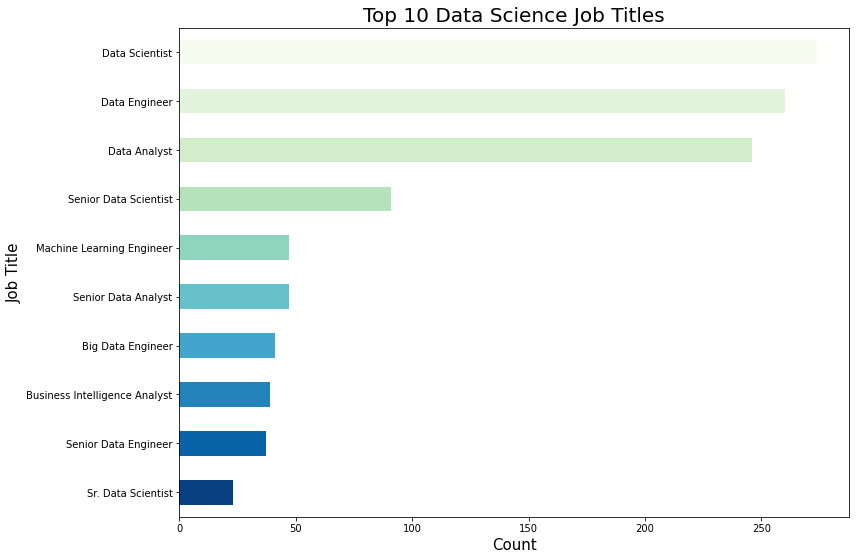

In [23]:
plt.rcParams['figure.figsize'] = (12,9) # set size of the graph
color = plt.cm.GnBu(np.linspace(0,1,10)) # set color
data["Job Title"].value_counts().sort_values(ascending=False).head(10).plot.barh(color=color) # horizontal bar chart
plt.title("Top 10 Data Science Job Titles",fontsize=20) # set title
plt.xlabel("Count",fontsize=15) # set label for x axis
plt.ylabel("Job Title",fontsize=15) # set label for y axis
plt.gca().invert_yaxis() # Descending order
plt.show()

We can see that the top 3 most popular job titles are Data Scientist, Data engineer, and Data Analyst. This is no different than what I expected.

**2. What are the top 10 locations (cities) with the highest number of job postings?**

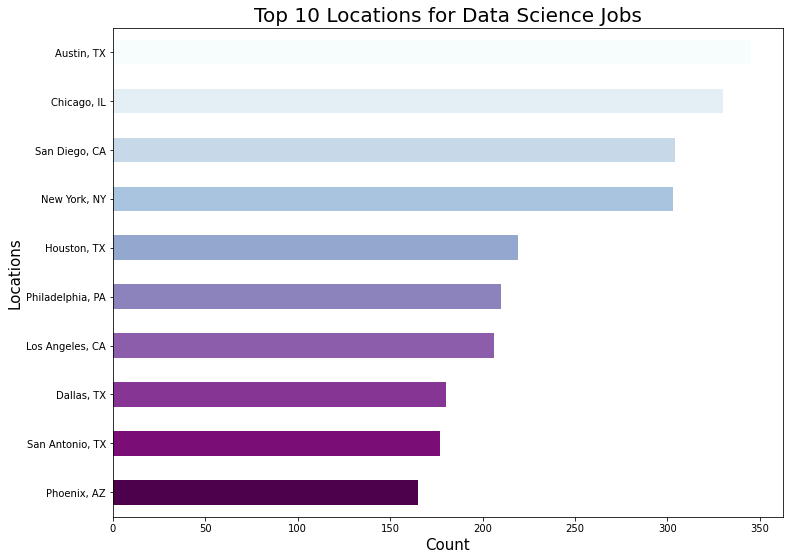

In [24]:
# Create a dataframe containing the top 10 locations with the most postings
plt.rcParams['figure.figsize'] = (12,9)
color = plt.cm.BuPu(np.linspace(0,1,10)) 
data["Location"].value_counts().sort_values(ascending=False).head(10).plot.barh(color=color)
plt.title("Top 10 Locations for Data Science Jobs",fontsize=20)
plt.xlabel("Count",fontsize=15)
plt.ylabel("Locations",fontsize=15)
plt.gca().invert_yaxis()
plt.show()

We can see that most jobs are located in big cities that have a lot of tech companies or businesses. I am a bit surprised to see that most data science jobs are in Austin and the numbers of jobs in New York and Los Angeles are lower than Austin.

**3. What is the salary ranges of data science jobs in the top 10 locations (cities) with the most postings in the United States?**

Text(0.5, 1.0, 'Top 10 Cities Hiring Data Science Jobs')

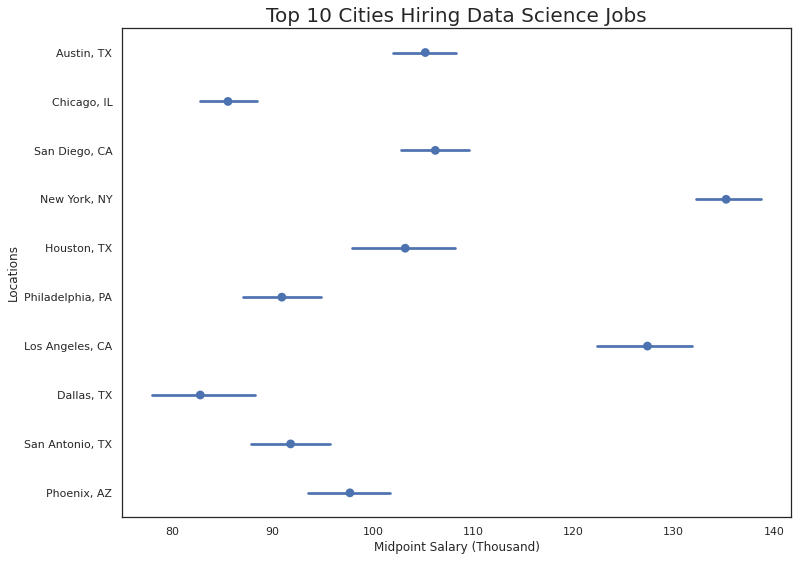

In [25]:
# Create a dataframe containing the top 10 locations
data_by_city = data.groupby('Location')['Job Title'].count().reset_index().sort_values(
    'Job Title',ascending=False).head(10).rename(columns={'Job Title':'Hires'})
# Left merge to find the salary by city
sal_by_city = data_by_city.merge(data,on='Location',how='left')
sns.set(style="white") # set style
plt.rcParams['figure.figsize'] = (12,9)
sns.pointplot(x='Midpoint Salary',y='Location',data=sal_by_city, join=False).set(
    ylabel="Locations",xlabel="Midpoint Salary (Thousand)") # pointplot for the salary
plt.title('Top 10 Cities Hiring Data Science Jobs',fontsize=20)


From this graph, we can see that although Austin, TX has the most jobs, the midpoint salary range is not the highest. The highest salary midpoint range is in New York, NY; followed by Los Angeles, CA. This makes sense.

**4. What are the top 10 most needed or most relevant skills based on the job description?**

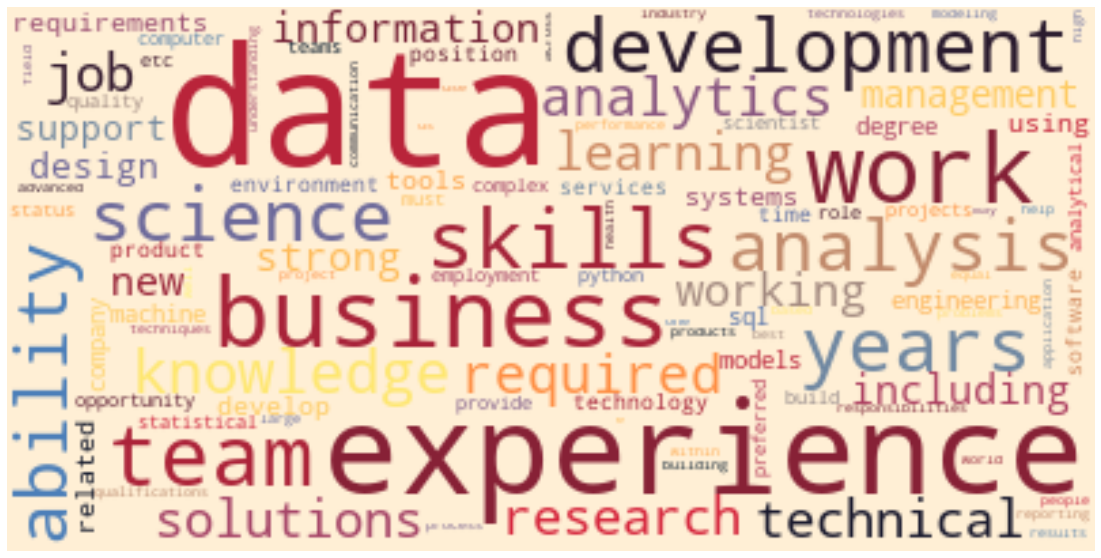

In [26]:
hero.wordcloud(data.JD, max_words=100)